In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [5]:
# 1. 데이터 불러오기 및 전처리
df = pd.read_csv('/Users/beok/Project/LLM_effection/regression/Student_Performance.csv')

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


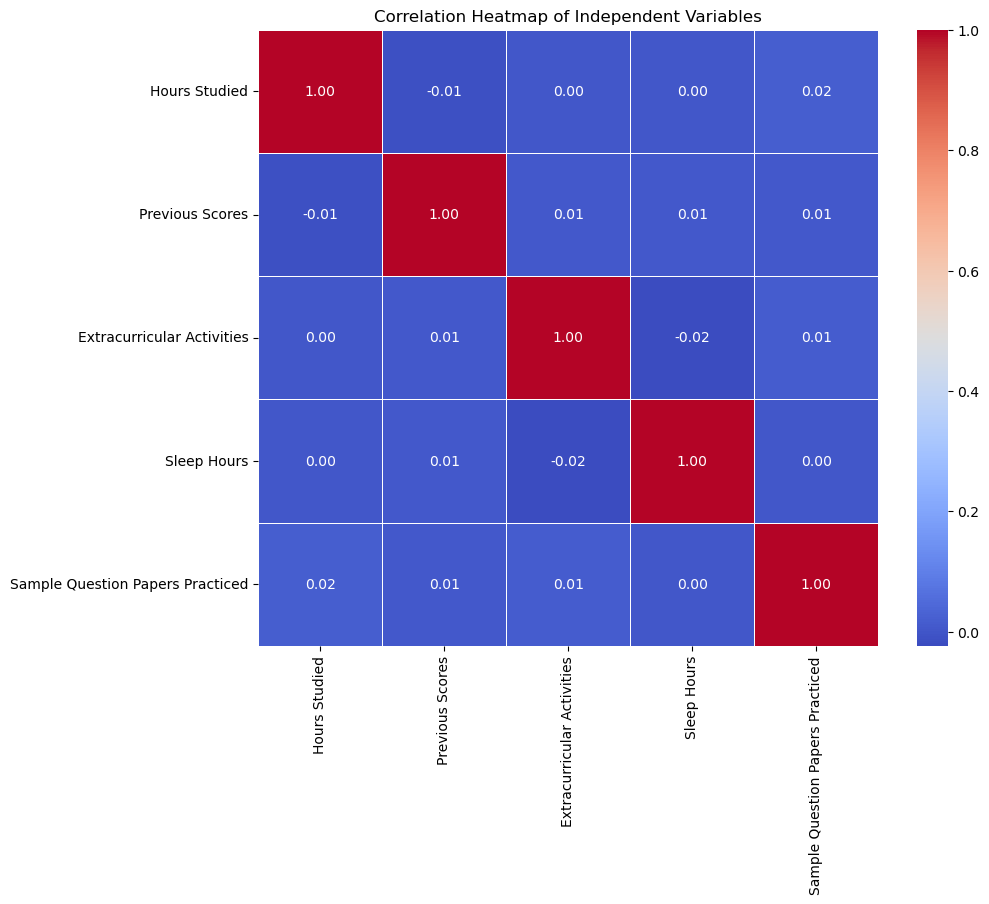

--- [다중공선성(VIF) 결과] ---
                            Feature        VIF
0                             const  38.916475
1                     Hours Studied   1.000478
2                   Previous Scores   1.000326
3        Extracurricular Activities   1.000802
4                       Sleep Hours   1.000600
5  Sample Question Papers Practiced   1.000557

* VIF < 10 이면 다중공선성 문제가 없는 것으로 판단합니다.


In [ ]:
# 범주형 변수(Extracurricular Activities) 수치화 (Yes: 1, No: 0)
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

# 독립변수(X)와 종속변수(y) 분리
X = df.drop('Performance Index', axis=1)
y = df['Performance Index']

# 2. 독립변수 간 상관관계 그래프 (Heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Independent Variables')
plt.show()

# 3. 다중공선성(VIF) 파악
X_with_const = sm.add_constant(X) # 상수항 추가 필수
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(len(X_with_const.columns))]

print("--- [다중공선성(VIF) 결과] ---")
print(vif_data)
print("\n* VIF < 10 이면 다중공선성 문제가 없는 것으로 판단합니다.")

In [3]:
# 4. 회귀분석 수행 (statsmodels OLS)
model = sm.OLS(y, X_with_const)
results = model.fit()

print("\n--- [회귀분석 요약 결과] ---")
print(results.summary())


--- [회귀분석 요약 결과] ---
                            OLS Regression Results                            
Dep. Variable:      Performance Index   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.757e+05
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:23:51   Log-Likelihood:                -21307.
No. Observations:               10000   AIC:                         4.263e+04
Df Residuals:                    9994   BIC:                         4.267e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [7]:
std_x = X.std()
std_y = y.std()

beta_std = results.params[1:] * (std_x / std_y)

print("\n--- [표준화 회귀계수(Standardized Beta)] ---")
print(beta_std)


--- [표준화 회귀계수(Standardized Beta)] ---
Hours Studied                       0.384501
Previous Scores                     0.919339
Extracurricular Activities          0.015950
Sleep Hours                         0.042418
Sample Question Papers Practiced    0.028924
dtype: float64


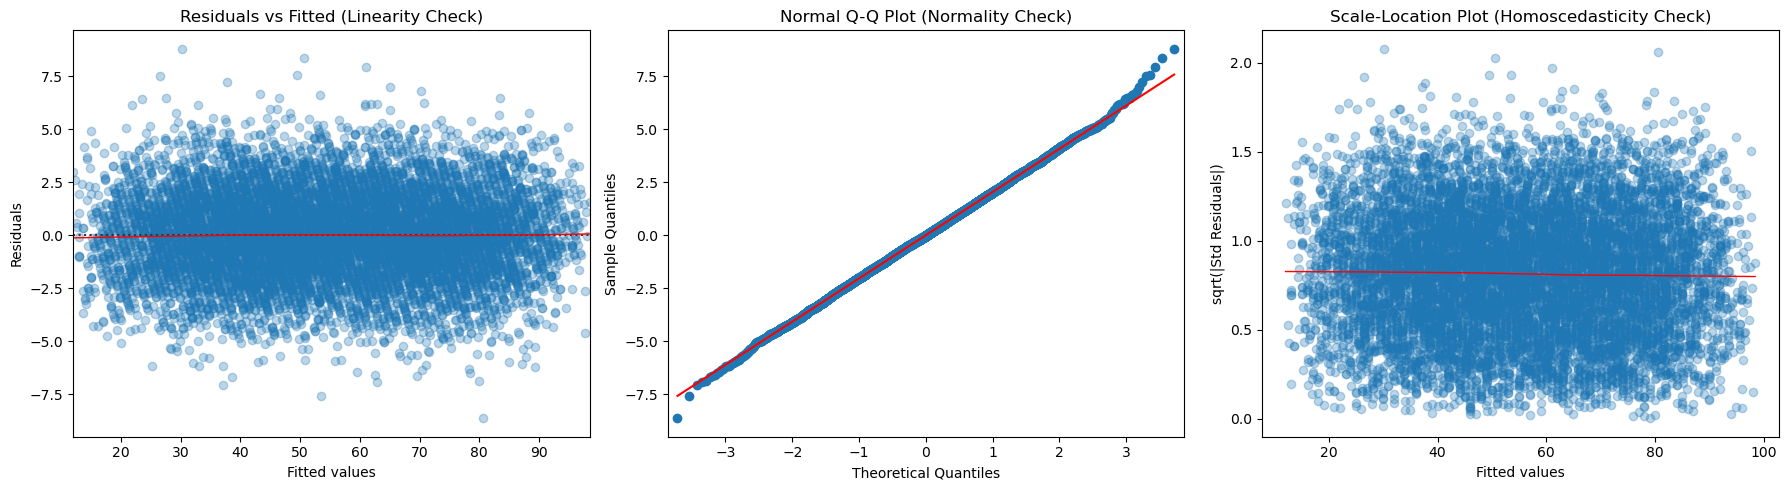


--- [잔차 정규성 검정 결과] ---
Shapiro-Wilk p-value: 0.3651


In [4]:
# 5. 잔차 분석 (3-in-1 시각화)
residuals = results.resid
fitted_values = results.fittedvalues

plt.figure(figsize=(18, 5))

# (1) 선형성 (Residuals vs Fitted)
plt.subplot(1, 3, 1)
sns.residplot(x=fitted_values, y=residuals, lowess=True, 
              scatter_kws={'alpha': 0.3}, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted (Linearity Check)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

# (2) 정규성 (Normal Q-Q Plot)
plt.subplot(1, 3, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Normal Q-Q Plot (Normality Check)')

# (3) 등분산성 (Scale-Location Plot)
plt.subplot(1, 3, 3)
standardized_residuals = np.sqrt(np.abs(results.get_influence().resid_studentized_internal))
plt.scatter(fitted_values, standardized_residuals, alpha=0.3)
sns.regplot(x=fitted_values, y=standardized_residuals, scatter=False, ci=None, lowess=True, 
            line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location Plot (Homoscedasticity Check)')
plt.xlabel('Fitted values')
plt.ylabel('sqrt(|Std Residuals|)')

plt.tight_layout()
plt.show()

# 6. 통계적 정규성 검정
shapiro_test = stats.shapiro(residuals[:5000]) # 샘플링 (Shapiro-Wilk는 5000개까지 권장)
print(f"\n--- [잔차 정규성 검정 결과] ---")
print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue:.4f}")